# **Recommender Systems**
# **Team 4 - Product Recommendation System**
## Vishal B - 19MIA1012
## Tharani K - 19MIA1033
## Parvathy AJ - 19MIA1048

### **Import Libraries**

In [1]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Split
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


### **Load Dataset**

In [3]:
df1=pd.read_csv("/content/ratings_Electronics.csv",names=['userId', 'productId','rating','timestamp'])

### **Data Analysis**

In [4]:
df1.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
print("Total Reviews:",df1.shape[0])
print("Total Columns:",df1.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [6]:
# Taking subset of the dataset
df = df1.iloc[:5000,0:]

In [7]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 5000
Total Columns: 4


In [8]:
print("Total number of ratings :",df.rating.nunique())
print("Total number of users   :", df.userId.nunique())
print("Total number of products  :", df.productId.nunique())

Total number of ratings : 5
Total number of users   : 4929
Total number of products  : 299


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     5000 non-null   object 
 1   productId  5000 non-null   object 
 2   rating     5000 non-null   float64
 3   timestamp  5000 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 156.4+ KB


In [10]:
# Check missing value
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [11]:
# Check Duplicate data
df[df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [12]:
# rating describe summary 
df.describe()['rating']

count    5000.000000
mean        3.986600
std         1.411814
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [13]:
print("Unique value of Rating:",df.rating.unique())

Unique value of Rating: [5. 1. 3. 2. 4.]


In [14]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


### **Data Visualization**

In [15]:
# Average rating of products
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['ratings_count'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


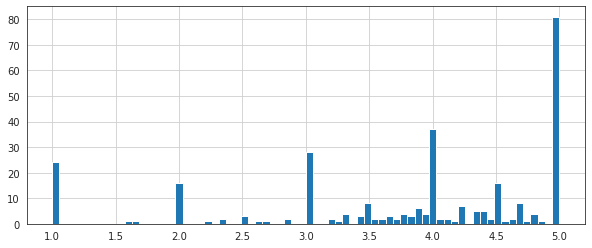

In [16]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

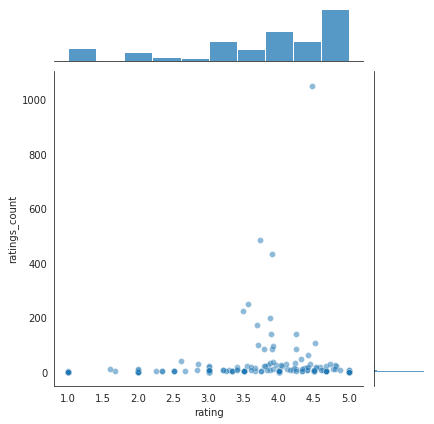

In [17]:
sns.jointplot(x='rating',y='ratings_count',data=ratings,alpha=0.5)

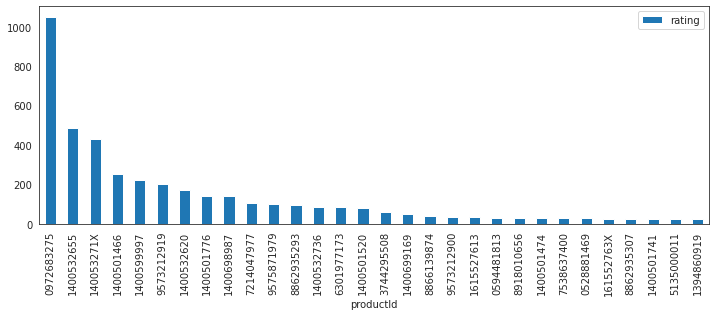

In [18]:
# Most top 30 products
popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

### **Popularity-Based**

<div align='left'><font size="3" color="#000000"> Weighted rating systems are used to score the rating of each product. Here is the formula of the weighted rating score.
</font></div>

<div align='center'><font size="4" color="#000000"> WR = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
</font></div>

<div align='left'><font size="3" color="#000000"> 
<ul>
  <li>R is the average rating for the item.</li>
  <li>v is the number of votes for the item.</li>
  <li>m is the minimum votes required to be listed in the popular items(defined by > percentile 80 of total votes)</li>
  <li>C is the average rating across the whole dataset.</li>
</ul>
</font></div>

In [19]:
vote_counts = ratings[ratings['ratings_count'].notnull()]['ratings_count'].astype('int')
vote_averages = ratings[ratings['ratings_average'].notnull()]['ratings_average'].astype('int')
C = vote_averages.mean()
print("Average rating of product across the whole dataset is",C)

Average rating of product across the whole dataset is 3.5953177257525084


In [20]:
m = vote_counts.quantile(0.95)
print("Minimum votes required to be listed in the chart is",m)

Minimum votes required to be listed in the chart is 62.19999999999925


In [21]:
ratings.head()

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852


In [22]:
qualified = ratings[(ratings['ratings_count'] >= m) & (ratings['ratings_count'].notnull()) & (ratings['ratings_average'].notnull())][['ratings_count', 'ratings_average']]

In [23]:
qualified['ratings_count'] = qualified['ratings_count'].astype('int')
qualified['ratings_average'] = qualified['ratings_average'].astype('int')
qualified.head().sort_values(by='ratings_count', ascending=False)

,ratings_count,ratings_average
productId,,
0972683275,1051,4
1400501466,250,3
1400532620,171,3
1400501776,139,3
1400501520,82,4


In [24]:
qualified.shape

(15, 2)

In [25]:
def weighted_rating(x):
    v = x['ratings_count']
    R = x['ratings_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [26]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [27]:
qualified = qualified.sort_values('wr', ascending=False).head(20)

#### Top 10 Products for recommendation using Popular-based method

In [28]:
qualified.head(10)

,ratings_count,ratings_average,wr
productId,,,
0972683275,1051,4,3.977388
1400698987,138,4,3.874270
7214047977,107,4,3.851234
1400501520,82,4,3.825442
6301977173,83,3,3.255019
1400532736,84,3,3.253275
8862935293,95,3,3.235552
9575871979,98,3,3.231141
1400501776,139,3,3.184040


Text(0, 0.5, 'Count')

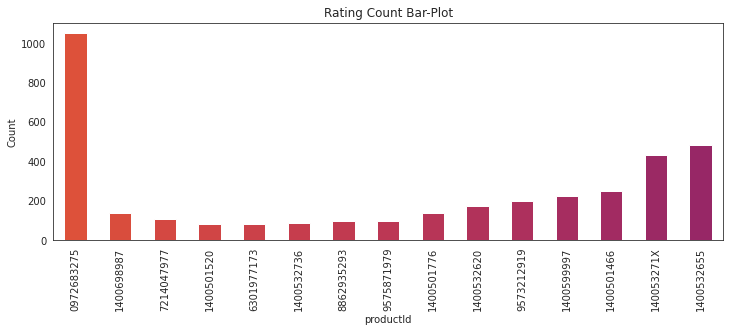

In [29]:
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))

rating_plot_count = qualified['ratings_count'].plot.bar(figsize=(12, 4),color=color)
rating_plot_count.set_title("Rating Count Bar-Plot")
rating_plot_count.set_xlabel("productId")
rating_plot_count.set_ylabel("Count")

Text(0, 0.5, 'rating')

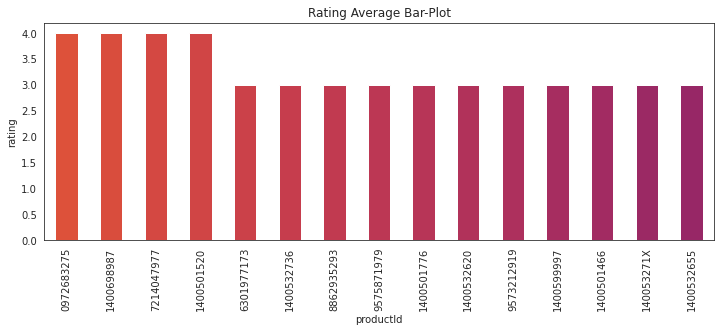

In [30]:
rating_plot_avg = qualified['ratings_average'].plot.bar(figsize=(12, 4),color=color)
rating_plot_avg.set_title("Rating Average Bar-Plot")
rating_plot_avg.set_xlabel("productId")
rating_plot_avg.set_ylabel("rating")

Text(0, 0.5, 'rating')

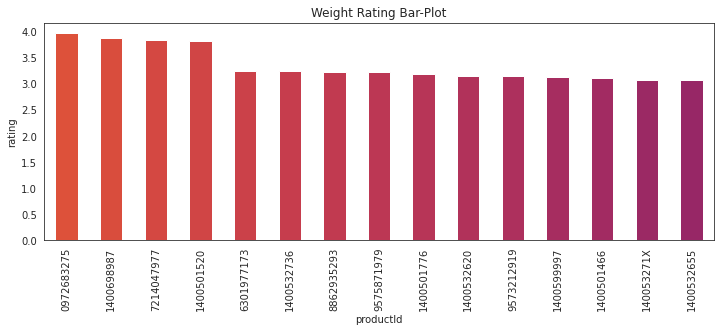

In [31]:
wr_plot = qualified['wr'].plot.bar(figsize=(12, 4),color=color)
wr_plot.set_title("Weight Rating Bar-Plot")
wr_plot.set_xlabel("productId")
wr_plot.set_ylabel("rating")

### **Collaborative Filtering (User-Item)**



In [32]:
reader = Reader()

In [33]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [34]:
data = Dataset.load_from_df(df[['userId', 'productId', 'rating']], reader)

In [35]:
# Use the famous SVD algorithm
svd = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3346  1.3819  1.3674  1.3735  1.3770  1.3669  0.0168  
MAE (testset)     1.0866  1.1197  1.1070  1.1197  1.1137  1.1093  0.0123  
Fit time          0.66    0.57    0.66    0.84    0.61    0.67    0.09    
Test time         0.06    0.04    0.01    0.02    0.01    0.03    0.02    


{'test_rmse': array([1.33462206, 1.38187296, 1.36741865, 1.37345241, 1.37704786]),
 'test_mae': array([1.08659106, 1.11972093, 1.10695719, 1.11971788, 1.11372155]),
 'fit_time': (0.6627216339111328,
  0.5709428787231445,
  0.6556971073150635,
  0.8422160148620605,
  0.6108405590057373),
 'test_time': (0.06450390815734863,
  0.038596153259277344,
  0.010948896408081055,
  0.017654895782470703,
  0.010602474212646484)}

<div align='left'><font size="3" color="#000000">From these results, the mean Root Mean Square Error is not good for our case, this happens due to several factors such as lack of training data because we only apply 5000 data. Now let's train our dataset and make some predictions.
</font></div>

In [36]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [37]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [38]:
df['userId'].value_counts()

A3LDPF5FMB782Z    5
A36V8NDDRZYRYO    3
A3E7PG9CHDBICA    3
AOY9SZTMNQWAW     3
A2FHM5FB0BXKGA    3
                 ..
A1W92X1R9QNM2C    1
A1KW4AGRCOIWI2    1
A1B6WHCBJSNO6J    1
A3BEVLI33Q0ZF4    1
A1TYKVIT4FTMRO    1
Name: userId, Length: 4929, dtype: int64

In [39]:
# Check specific userId review
df[df['userId'] == 'A3LDPF5FMB782Z']

,userId,productId,rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1588,A3LDPF5FMB782Z,1400501520,5.0,1362873600
1696,A3LDPF5FMB782Z,1400501776,5.0,1334102400
2502,A3LDPF5FMB782Z,140053271X,4.0,1310515200
3235,A3LDPF5FMB782Z,1400698987,4.0,1392854400


In [60]:
# predict based on this data
svd.predict('A3LDPF5FMB782Z', '1400501776')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501776', r_ui=None, est=4.809299377833505, details={'was_impossible': False})

<div align='left'><font size="3" color="#000000">From the prediction results, we have estimation that are quite close to the actual value.
</font></div>

## **Cosine Similarity**

### Filtering the dataset

In [41]:
ratings_per_user = df1.groupby('userId')['rating'].count()
ratings_per_product = df1.groupby('productId')['rating'].count()

In [42]:
#removing products with less number of ratings
ratings_per_product_df =pd.DataFrame(ratings_per_product)
filtered_ratings_per_products_df = ratings_per_product_df[ratings_per_product_df.rating>=850]
popular_product = filtered_ratings_per_products_df.index.tolist()
print(filtered_ratings_per_products_df)

            rating
productId         
0972683275    1051
B00001P4ZH    2075
B00001WRSJ    1586
B00004SABB    1030
B00004SB92    1006
...            ...
B00FFJ0HUE    1278
B00FNPD1VW    1607
B00G2TK76A     998
B00GTGETFG    2667
B00INNP5VU    1097

[858 rows x 1 columns]


In [43]:
#removing users who gave low number of ratings
ratings_per_user_df = pd.DataFrame(ratings_per_user)
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating>= 70]
pro_users = filtered_ratings_per_user_df.index.tolist()
print(filtered_ratings_per_user_df)

                rating
userId                
A100UD67AHFODS     116
A100WO06OQR8BQ     132
A105TOJ6LTVMBG      71
A10NMELR4KX0J6      96
A10O7THJ2O20AG      80
...                ...
AYNAH993VDECT       81
AYOTEJ617O60K       81
AZ515FFZ7I2P7      144
AZAC8O310IK4E      103
AZMY6E8B52L2T      189

[688 rows x 1 columns]


In [45]:
filtered_ratings = df1[df1.productId.isin(popular_product)]
filtered_ratings = df1[df1.userId.isin(pro_users)]

len(filtered_ratings)

76682

### Matrix to see user-product matches

In [46]:
#converting matrix to pivot table
rating_matrix = pd.pivot_table(filtered_ratings, index='userId', columns = 'productId',values='rating' )
#converting null values to 0
rating_matrix = rating_matrix.fillna(0)

n_users = len(rating_matrix.index)
n_products = len(rating_matrix.columns)

print(f"Users: {n_users}\nProducts: {n_products}")

rating_matrix.head()

Users: 688
Products: 33428


productId,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400699169,1685560148,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
def train_test_split(data: np.array, n_users: int, n_products:int): 
    # we created 0 matrices to create the test matrix
    test = np.zeros((n_users, n_products))
    train = data.copy()
    
    #for each user, we reserve the 5 products they bought for testing
    for user in range(n_users):
        random_sample = np.random.choice(data[user, :].nonzero()[0], 
                                         size=5, 
                                         replace=False)
        # equal 0 as if they did not receive the products we just pulled in the train
        train[user, random_sample] = 0. 
        test[user, random_sample] = data[user, random_sample]
        
    return train, test
train, test = train_test_split(data=rating_matrix.to_numpy(), n_users=n_users, n_products=n_products)

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

In [48]:
#convert train matrix to dataframe
train_df.index = rating_matrix.index
train_df.columns = rating_matrix.columns
train_df

productId,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400699169,1685560148,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYNAH993VDECT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOTEJ617O60K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ515FFZ7I2P7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#convert test matrix to dataframe
test_df.index = rating_matrix.index
test_df.columns = rating_matrix.columns
test_df

productId,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400699169,1685560148,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYNAH993VDECT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOTEJ617O60K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ515FFZ7I2P7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine Similarity

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def similar_users(userId, matrix,k=3):
    #find user we want to suggest in train and we distinguish that user from other users
    user = matrix[matrix.index == userId]
    other_users = matrix[matrix.index != userId]
    
    #we find cosine similarity between users with the help of function
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    indices = other_users.index.tolist()
    
    #we put in a dictionary the users and their similarity numbers with the users we choose 
    index_similarity = dict(zip(indices, similarities))
    
    #we sort this dictionary by similarity from highest to lowest
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    #We choose the k most similar users
    top_users_similarities = index_similarity_sorted[:k]
    
    users = [u[0] for u in top_users_similarities]
    
    return users

current_user = input("Enter user: ")

similar_user_indices = similar_users(current_user,train_df)
print(similar_user_indices)

Enter user: A100UD67AHFODS
['A11FX8HL2ANK6T', 'A2NOW4U7W3F7RI', 'A3CG93783LP0FO']


### Recommending Product

In [52]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    
    # average rating of similar people
    similar_users = similar_users.mean(axis=0)
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    user_df = matrix[matrix.index == user_index]
    user_df_transposed = user_df.transpose()

    user_df_transposed.columns = ['rating']
    # we leave items not yet purchased 
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # we list unpurchased items into a list
    not_purchased_prod = user_df_transposed.index.tolist()
    
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # We offer as many suggestions as desired 
    top_n_product = similar_users_df_ordered.head(items)
    top_n_product_indices = top_n_product.index.tolist()
    
    product_information = df1[df1['productId'].isin(top_n_product_indices)]
    
    print(product_information.groupby('productId').mean())
    
    test_filtered_df = test_df[test_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)

    return top_n_product_indices 

results = recommend_item(current_user, similar_user_indices, train_df)
print()
print(results)

              rating     timestamp
productId                         
B001E1Y5O6  4.715512  1.358704e+09
B001F7AHOG  4.329615  1.339034e+09
B003ES5ZUU  4.704749  1.372443e+09
B005HMKKH4  4.350016  1.371360e+09
B007DL79FS  4.370000  1.375449e+09

['B003ES5ZUU', 'B005HMKKH4', 'B007DL79FS', 'B001E1Y5O6', 'B001F7AHOG']


In [54]:
df1[df1['userId'] == current_user]

,userId,productId,rating,timestamp
66537,A100UD67AHFODS,B00004Z5M1,5.0,1350086400
123861,A100UD67AHFODS,B00005T3X7,5.0,1354665600
165910,A100UD67AHFODS,B000069EUW,5.0,1351814400
166702,A100UD67AHFODS,B000069JWX,1.0,1070841600
322741,A100UD67AHFODS,B0000AR0I4,5.0,1353369600
...,...,...,...,...
7173279,A100UD67AHFODS,B00BUACE8K,5.0,1380758400
7565606,A100UD67AHFODS,B00ETH7ERM,4.0,1385942400
7585855,A100UD67AHFODS,B00F0DD0I6,5.0,1381622400
7638959,A100UD67AHFODS,B00FISD9DO,4.0,1388361600


In [55]:
#We look at the products in our Test Matrix
m1 = (test_df.index == current_user)
m2 = (test_df[m1] != 0).all()
a = test_df.loc[m1,m2]
print(a)

productId       B000J0072M  B000Q8UAWY  B00108UNEY  B0088PU86K  B00A83I8G2
userId                                                                    
A100UD67AHFODS         3.0         5.0         5.0         5.0         5.0


We give an estimated score using users who are similar to products in our test matrix. The function below works in the same logic as the function we defined above and then used to score the estimate on the data in the train. The only difference between the two is that we use the test data as data here and we try to score the products in the test data, so we choose the products that have already received points.

In [57]:
def recommend_item2(user_index, similar_user_indices, matrix, items=5):
    
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    

    similar_users = similar_users.mean(axis=0)
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    user_df = matrix[matrix.index == user_index]
    user_df_transposed = user_df.transpose()

    user_df_transposed.columns = ['rating']
    #we choose the product that the user we selected has previously rated. 
    user_df_transposed = user_df_transposed[user_df_transposed['rating']!=0]

    not_purchased_prod = user_df_transposed.index.tolist()
    
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)

    top_n_product = similar_users_df_ordered.head(items)
    top_n_product_indices = top_n_product.index.tolist()
    
    product_information = df1[df1['productId'].isin(top_n_product_indices)]
    
    print(product_information.groupby('productId').mean())
    
    test_filtered_df = test_df[test_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)

    return top_n_product_indices 

In [58]:
# we select the products rated by the user we selected in the test matrix
m1 = (test_df.index == current_user)
m2 = (test_df[m1] != 0).all()
a = test_df.loc[m1,m2]

In [59]:
#Scores from the recommend_item2 function
results2 = recommend_item2(current_user, similar_user_indices, a)

              rating     timestamp
productId                         
B000J0072M  3.400000  1.312338e+09
B000Q8UAWY  4.360728  1.338302e+09
B00108UNEY  4.792208  1.360000e+09
B0088PU86K  3.915663  1.365905e+09
B00A83I8G2  4.546539  1.381756e+09
